In [1]:
# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import importlib
from libs import trades, plots, params, models
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)

import sys
print(sys.executable)

import math
import pandas as pd
from pandas import Timestamp
import numpy as np
import glob
import os
import json

import datetime as dt
from datetime import datetime
from pprint import pprint
from collections import OrderedDict

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from IPython.display import display, HTML
import seaborn as sns

from typing import Optional, Dict, Tuple, List, Sequence
from sklearn.preprocessing import StandardScaler

from tqdm.auto import tqdm
tqdm.pandas()        

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


/usr/bin/python


In [2]:
ticker = params.ticker
base_csv = params.base_csv

# 1) Glob all ticker-specific JSONs
pattern = os.path.join(params.optuna_folder, f"{ticker}_*.json")
files   = glob.glob(pattern)

# 2) Pick the one with the largest value in its filename
#     filenames are like "AAPL_0.603650.json"
best_file = max(
    files,
    key=lambda fn: float(os.path.basename(fn)
                              .replace(f"{ticker}_", "")
                              .replace(".json", ""))
)

# 3) Load it
with open(best_file) as fp:
    best_record = json.load(fp)

best_value  = best_record["value"]
best_params = best_record["params"]

print(f"Using best Optuna trial {best_value:.6f}:")

# adjust the best_params dictionary with exactly the hyperparameters that the function run_trading_pipeline needs

minutes_total = (
    params.regular_start.hour * 60
  + params.regular_start.minute
)

look_back = best_params.pop("look_back")

regular_start_pred = dt.time(*divmod(minutes_total - look_back, 60))
regular_start_shifted = dt.time(*divmod(minutes_total - look_back*2, 60))

best_params["regular_start_shifted"] = regular_start_shifted 

best_params

Using best Optuna trial 0.699445:


{'min_prof_thr': 0.2624509797850209,
 'max_down_prop': 0.9213845439335194,
 'gain_tightening_factor': 0.25828944358735195,
 'merging_retracement_thr': 0.25823546476264014,
 'merging_time_gap_thr': 0.5763622603776724,
 'pre_entry_decay': 0.5759612815763134,
 'short_penalty': 0.86363584624204,
 'trailing_stop_thresh': 0.05110451500436188,
 'buy_threshold': 0.18677368993963356,
 'regular_start_shifted': datetime.time(12, 30)}

[main] Found existing base CSV: dfs_training/AAPL_1_base.csv


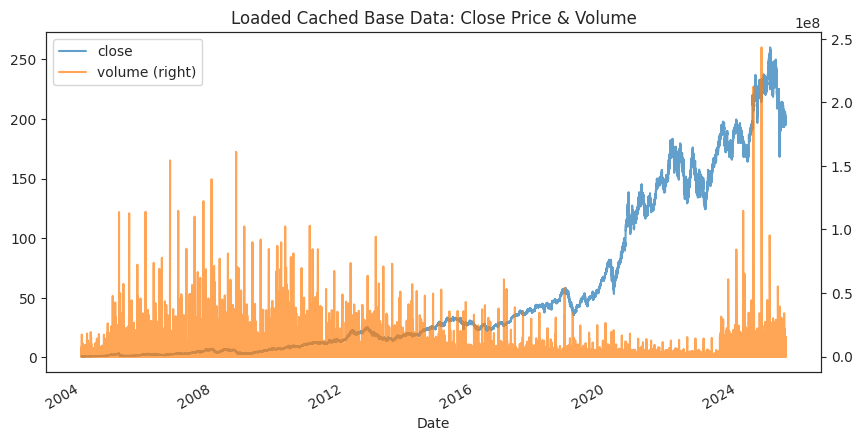

In [3]:

if os.path.exists(base_csv):
    # -----------------------------------------------------------------
    # 1) Cached file exists → load it, plot it, skip all processing.
    # -----------------------------------------------------------------
    print(f"[main] Found existing base CSV: {base_csv}")
    df = pd.read_csv(base_csv, index_col=0, parse_dates=True)
    plots.plot_close_volume(
        df,
        title="Loaded Cached Base Data: Close Price & Volume"
    )

else:
    # -----------------------------------------------------------------
    # 2) No cached file → do the full split‐adjust and then minute‐grid prep
    # -----------------------------------------------------------------
    print(f"[main] No base CSV found; running process_splits …")
    df_raw = trades.process_splits(
        folder                   = params.stocks_folder,
        ticker                   = ticker,
        bidasktoclose_spread     = params.bidasktoclose_spread
    )

    # Once‐only minute grid build and interpolation
    print(f"[main] Running prepare_interpolate_data …")
    df = trades.prepare_interpolate_data(
        df                    = df_raw,
        regular_start_shifted = best_params["regular_start_shifted"],
        regular_start         = params.regular_start,
        regular_end           = params.regular_end
    )
    
    # Persist to base CSV and return
    df.to_csv(base_csv)
    print(f"[process_splits] Saved processed data to: {base_csv}")

# df is now guaranteed to be the split‐adjusted, minute‐aligned DataFrame
df


In [7]:
# def process_single_day(day_str): 
#     # Processes one calendar day, called by the function 'saveDF_checkDAY'
#     print(f"\n=== Processing trading day {day_str} ===")
#     day_dt = pd.to_datetime(day_str)
#     day_df = df.loc[df.index.normalize() == day_dt].copy()
#     if day_df.empty:
#         print(" no data; skipping.")
#         return
            
#     print("\n Running trading pipeline on selected date …")
#     result = trades.run_trading_pipeline(day_df, 
#                                          col_signal='signal',
#                                          col_action='signal_action',
#                                          day_to_check=day_str)
    
#     if result is None:
#         print(" no trades found; skipping.")
#         return

#     df_day, trades_day, perf_day = result
#     plots.plot_trades(
#         df=df_day,
#         col_signal1='signal',
#         col_signal2=False,
#         col_action='signal_action',
#         trades=trades_day,
#         buy_threshold=params.buy_threshold_tick,
#         performance_stats=perf_day
#     )

#     print(f"\n* Performance for {day_dt} *")
#     for k, v in perf_day.items():
#         print(f"{k}: {v}")

#     return df_day, perf_day



def process_single_day(day_str: str, hyperparams: dict, regular_start_pred):
    """
    Process and plot a single trading session using a given set of hyperparameters.

    Returns:
      Tuple[pd.DataFrame, Dict] | None
        If a valid backtest runs, returns (df_day, perf_day).
        If no data or no trades, returns None.
    """
    print(f"\n=== Processing trading day {day_str} ===")
    day_dt = pd.to_datetime(day_str)
    # Extract that day’s full-minute bars from the master df
    day_df = df.loc[df.index.normalize() == day_dt].copy()
    if day_df.empty:
        print(" no data; skipping.")
        return

    print("\n Running trading pipeline on selected date …")
    # Call run_trading_pipeline with your per-day slice + EXACTLY the same hyperparams
    result = trades.run_trading_pipeline(
                                        df                       = day_df,
                                        col_signal               = 'signal',
                                        col_action               = 'signal_action',
                                        day_to_check             = day_str,
                                        **hyperparams            # unpack your tuned parameters here
    )
    if result is None:
        print(" no trades found; skipping.")
        return

    # Unpack pipeline output: (df_signals, trades_list, performance_stats)
    df_day, trades_day, perf_day = result

    # Plot the equity & trade markers
    plots.plot_trades(
                    df                 = df_day,
                    col_signal1        = 'signal',
                    col_signal2        = False,
                    col_action         = 'signal_action',
                    trades             = trades_day,
                    buy_threshold      = hyperparams['buy_threshold'],
                    performance_stats  = perf_day,
                    regular_start_pred = regular_start_pred
    )

    # Print the per-day summary
    print(f"\n* Performance for {day_dt.date()} *")
    for k, v in perf_day.items():
        print(f"  {k}: {v}")

    return df_day, perf_day


In [8]:
# def saveDF_checkDAY(df):
#     """
#     Backtest in two modes and optionally save a full‐run CSV of signals.

#     Modes:
#       • Month mode (params.date_to_check = 'YYYY-MM'):
#           – process each trading day via process_single_day()
#           – plot monthly aggregate performance
#           – return the month’s concatenated DataFrame (empty if none)
#       • Full‐run mode (params.createCSVsign == True):
#           – run the identical pipeline used by Optuna over all days
#           – compute & print the full‐period summary
#           – plot full‐period performance (now on df_all)
#           – isolate & compute the test‐period summary
#           – plot test‐period performance (on df_test)
#           – save every day’s signals to params.sign_csv
#           – return the full‐run DataFrame
#     """
#     keep_cols = [
#         "open", "high", "low", "close",
#         "volume", "bid", "ask",
#         "StrategyEarning", "EarningDiff",
#         "signal", "signal_action"
#     ]

#     # ── Month mode ────────────────────────────────────────────────────
#     print(f"\nMonth mode: processing {params.date_to_check}")
#     month_days = (
#         df.loc[df.index.strftime("%Y-%m") == params.date_to_check]
#           .index
#           .normalize()
#           .unique()
#     )

#     month_frames, month_stats = [], []
#     for day in sorted(month_days):
#         res = process_single_day(str(day.date()))
#         if res is None:
#             continue
#         df_day, stats = res
#         month_frames.append(df_day)
#         month_stats.append(stats)

#     if not month_frames:
#         print("No valid days in this month.")
#         return pd.DataFrame(columns=keep_cols)

#     df_month = pd.concat(month_frames).sort_index()
#     plots.aggregate_performance(month_stats, df_month)

#     if not params.createCSVsign:
#         return df_month

#     # ── Full‐run mode ────────────────────────────────────────────────
#     print("\nFull‐run mode")
#     print("• Running trading pipeline on full dataset …")
#     full_sim_results = trades.run_trading_pipeline(
#         df=df,
#         col_signal='signal',
#         col_action='signal_action'
#     )

#     # Build combined DataFrame & performance list (with zeros on no‐trade days)
#     daily_frames = [res[0][keep_cols] for res in full_sim_results.values()]
#     df_all       = pd.concat(daily_frames).sort_index()
#     perf_all     = [res[2] for res in full_sim_results.values()]

#     print("\nFull‐period performance:")
#     plots.aggregate_performance(perf_all, df_all)

#     # Compute test‐period metrics & plot on df_all subset
#     days_all  = df_all.index.normalize().unique()
#     cutoff    = int(len(days_all) * (params.train_prop + params.val_prop))
#     test_days = days_all[cutoff:]
#     df_test   = df_all[df_all.index.normalize().isin(test_days)]
#     perf_test = [
#         stats
#         for day, (_, _, stats) in full_sim_results.items()
#         if pd.Timestamp(day).normalize() in test_days
#     ]

#     print("\nTest‐period performance:")
#     plots.aggregate_performance(perf_test, df_test)

#     # Save signals CSV
#     print("\n• Saving signals CSV …")
#     df_all.to_csv(params.sign_csv)
#     print(f"Saved to {params.sign_csv}")

#     return df_all


def saveDF_checkDAY(df: pd.DataFrame, hyperparams: dict):
    """
    Backtest in two modes and optionally save a full‐run CSV of signals,
    using the supplied hyperparameters.

    Modes:
      • Month mode (params.date_to_check = 'YYYY-MM'):
          – process each trading day via process_single_day(..., hyperparams)
          – plot monthly aggregate performance
          – return the month’s concatenated DataFrame (empty if none)

      • Full‐run mode (params.createCSVsign == True):
          – run the identical pipeline used by Optuna over all days
            with **hyperparams
          – compute & print the full‐period summary
          – plot full‐period performance
          – isolate & compute the test‐period summary
          – plot test‐period performance
          – save every day’s signals to params.sign_csv
          – return the full‐run DataFrame
    """
    keep_cols = [
        "open","high","low","close",
        "volume","bid","ask",
        "StrategyEarning","EarningDiff",
        "signal","signal_action"
    ]

    # ── Month mode ────────────────────────────────────────────────────
    print(f"\nMonth mode: processing {params.date_to_check}")
    month_days = (
                df.loc[df.index.strftime("%Y-%m") == params.date_to_check]
                  .index.normalize()
                  .unique()
    )

    month_frames, month_stats = [], []
    for day in sorted(month_days):
        # Pass hyperparams into process_single_day
        res = process_single_day(day_str = str(day.date()), 
                                 hyperparams = hyperparams, 
                                 regular_start_pred = regular_start_pred)
        if res is None:
            continue
        df_day, stats = res
        month_frames.append(df_day)
        month_stats.append(stats)

    if not month_frames:
        print("No valid days in this month.")
        return pd.DataFrame(columns=keep_cols)

    df_month = pd.concat(month_frames).sort_index()
    plots.aggregate_performance(month_stats, df_month)

    # If we aren’t saving a full-run CSV, bail out
    if not params.createCSVsign:
        return df_month

    # ── Full‐run mode ────────────────────────────────────────────────
    print("\nFull‐run mode")
    print("• Running trading pipeline on full dataset …")
    # Unpack hyperparams into run_trading_pipeline exactly as in Optuna
    full_sim_results = trades.run_trading_pipeline(
                                                    df            = df,
                                                    col_signal    = 'signal',
                                                    col_action    = 'signal_action',
                                                    **hyperparams
    )

    # 1) Build combined DF & perf list (zeros on no‐trade days)
    daily_frames = [res[0][keep_cols] for res in full_sim_results.values()]
    df_all       = pd.concat(daily_frames).sort_index()
    perf_all     = [res[2] for res in full_sim_results.values()]

    # 2) Print & plot full‐period performance using df_all
    print("\nFull‐period performance:")
    plots.aggregate_performance(perf_all, df_all)

    # 3) Test‐period slice & plot
    days_all  = df_all.index.normalize().unique()
    cutoff    = int(len(days_all) * (params.train_prop + params.val_prop))
    test_days = days_all[cutoff:]
    df_test   = df_all[df_all.index.normalize().isin(test_days)]
    perf_test = [
        stats
        for day, (_, _, stats) in full_sim_results.items()
        if pd.Timestamp(day).normalize() in test_days
    ]

    print("\nTest‐period performance:")
    plots.aggregate_performance(perf_test, df_test)

    # 4) Save the full-run signals CSV
    print("\n• Saving signals CSV …")
    df_all.to_csv(params.sign_csv)
    print(f"Saved to {params.sign_csv}")

    return df_all



Month mode: processing 2015-05

=== Processing trading day 2015-05-01 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


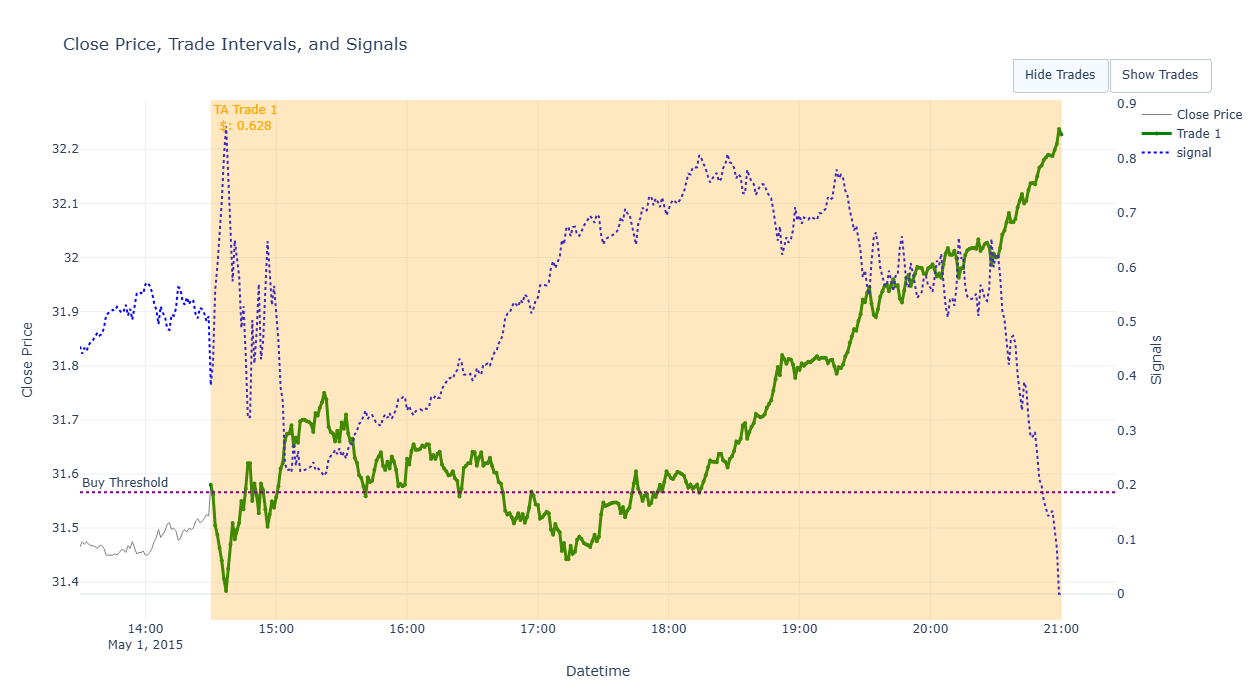


* Performance for 2015-05-01 *
  Buy & Hold Return ($): 0.628
  Strategy Return ($): 0.628
  Trades Returns ($): [0.628]

=== Processing trading day 2015-05-04 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


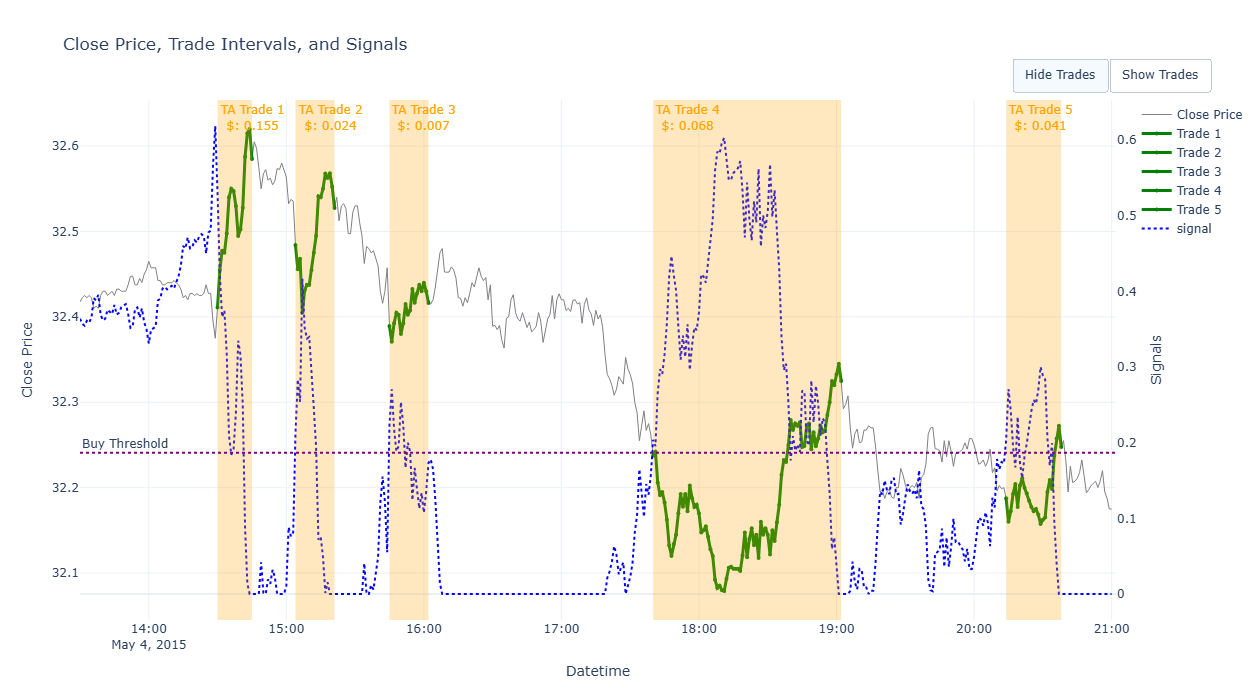


* Performance for 2015-05-04 *
  Buy & Hold Return ($): -0.255
  Strategy Return ($): 0.295
  Trades Returns ($): [0.155, 0.024, 0.007, 0.068, 0.041]

=== Processing trading day 2015-05-05 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


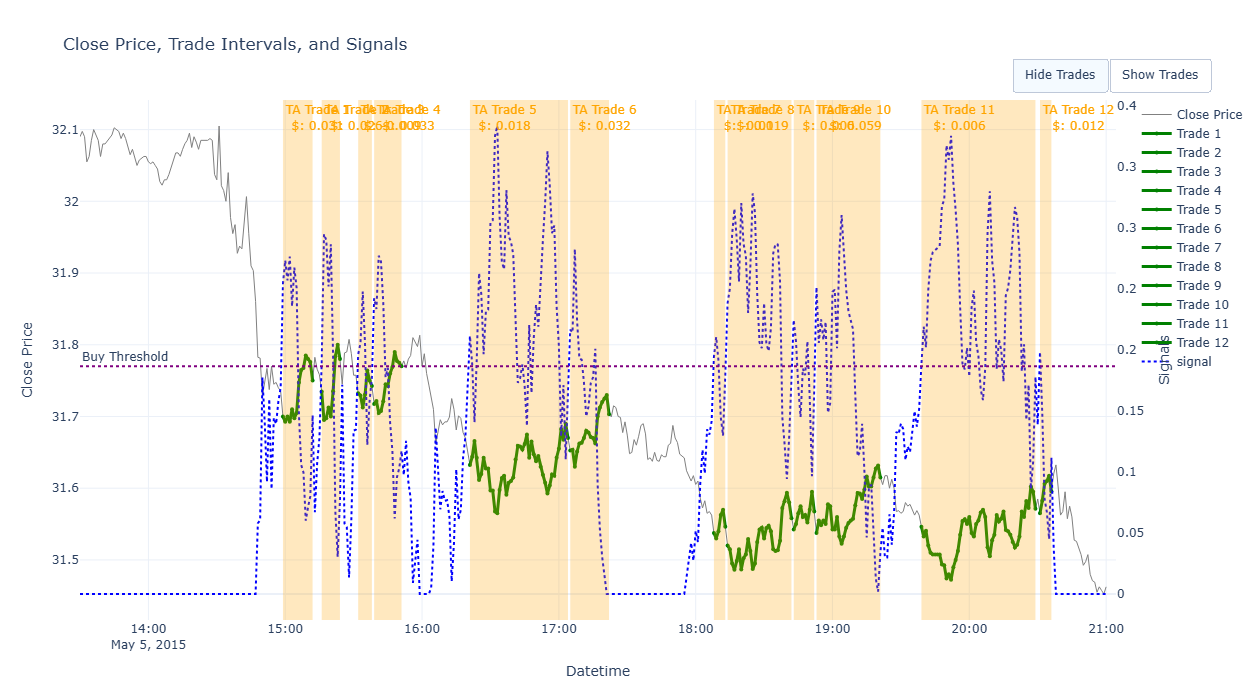


* Performance for 2015-05-05 *
  Buy & Hold Return ($): -0.587
  Strategy Return ($): 0.223
  Trades Returns ($): [0.031, 0.026, -0.009, 0.033, 0.018, 0.032, -0.01, 0.019, 0.006, 0.059, 0.006, 0.012]

=== Processing trading day 2015-05-06 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


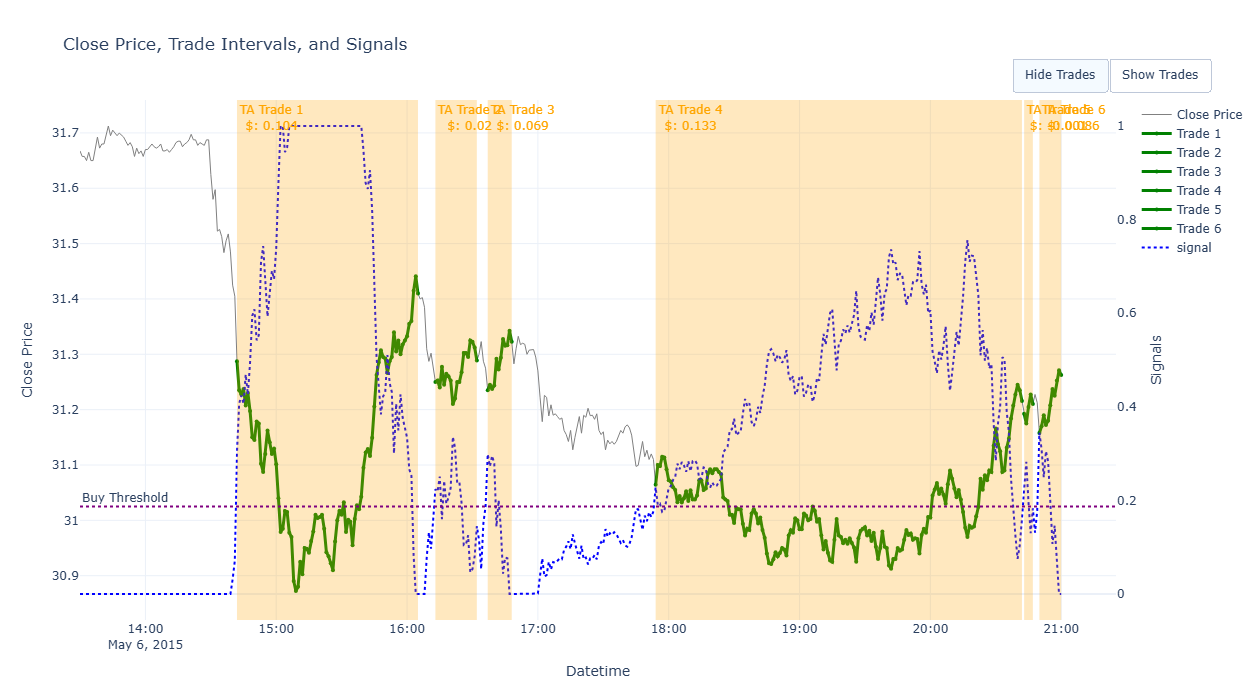


* Performance for 2015-05-06 *
  Buy & Hold Return ($): -0.381
  Strategy Return ($): 0.41
  Trades Returns ($): [0.104, 0.02, 0.069, 0.133, -0.001, 0.086]

=== Processing trading day 2015-05-07 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


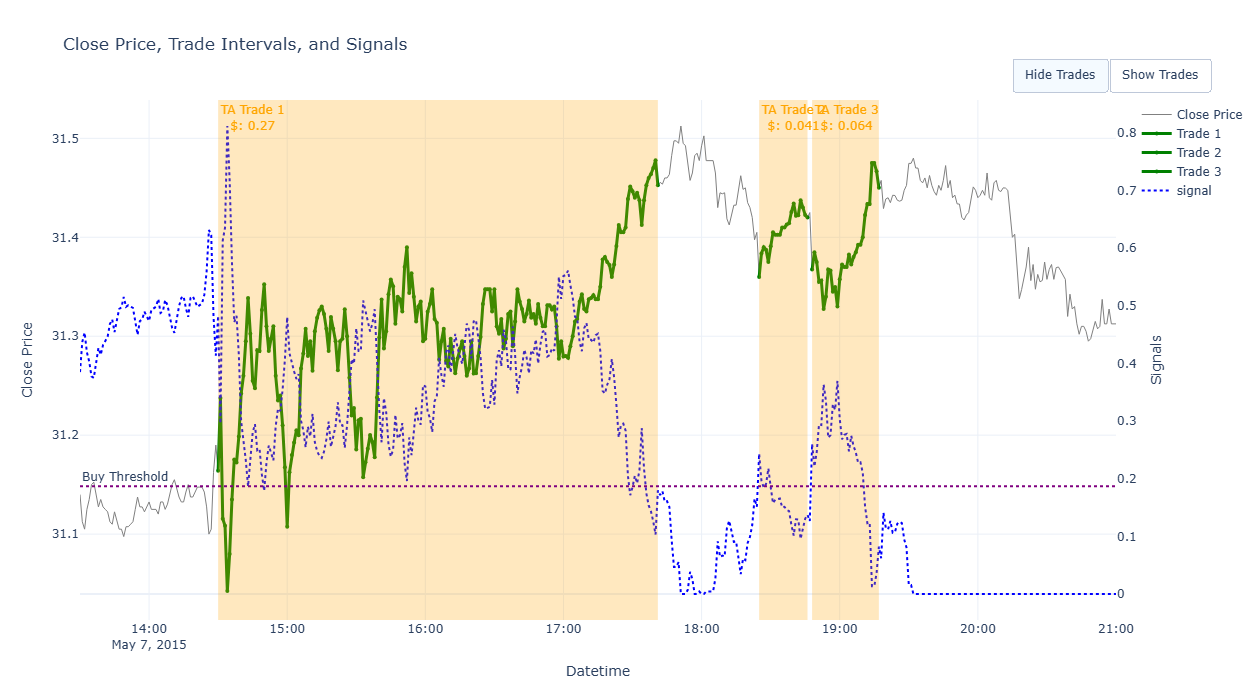


* Performance for 2015-05-07 *
  Buy & Hold Return ($): 0.13
  Strategy Return ($): 0.375
  Trades Returns ($): [0.27, 0.041, 0.064]

=== Processing trading day 2015-05-08 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


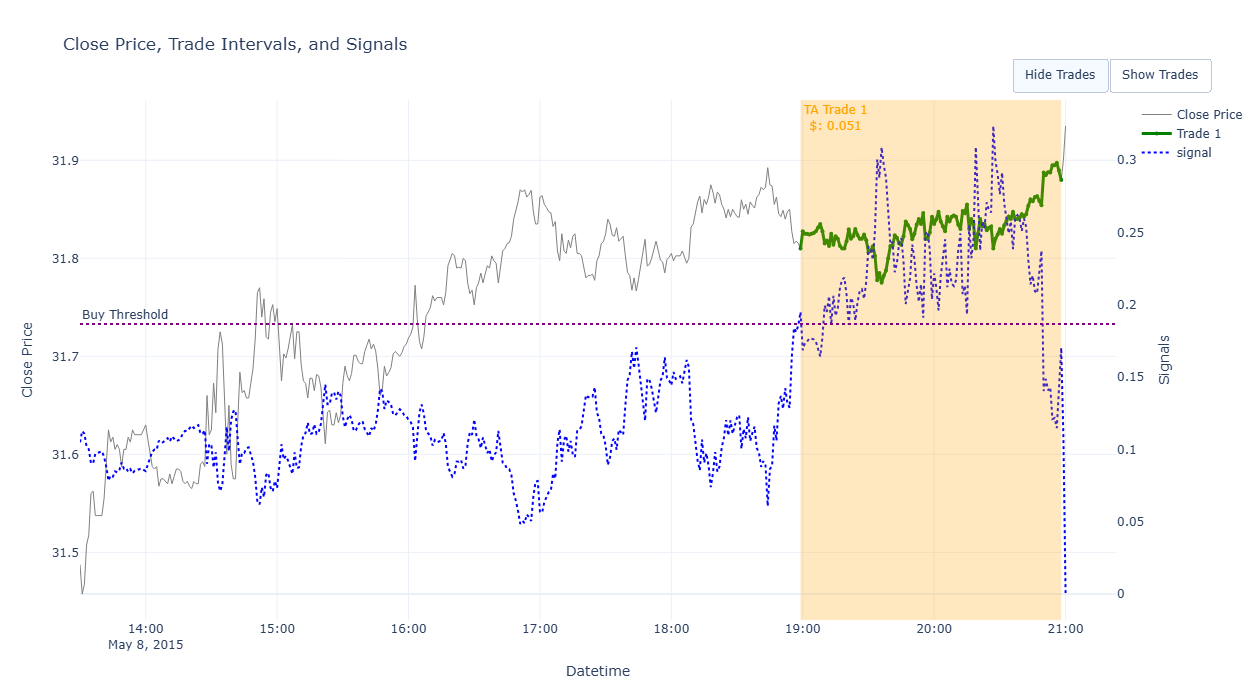


* Performance for 2015-05-08 *
  Buy & Hold Return ($): 0.291
  Strategy Return ($): 0.051
  Trades Returns ($): [0.051]

=== Processing trading day 2015-05-11 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


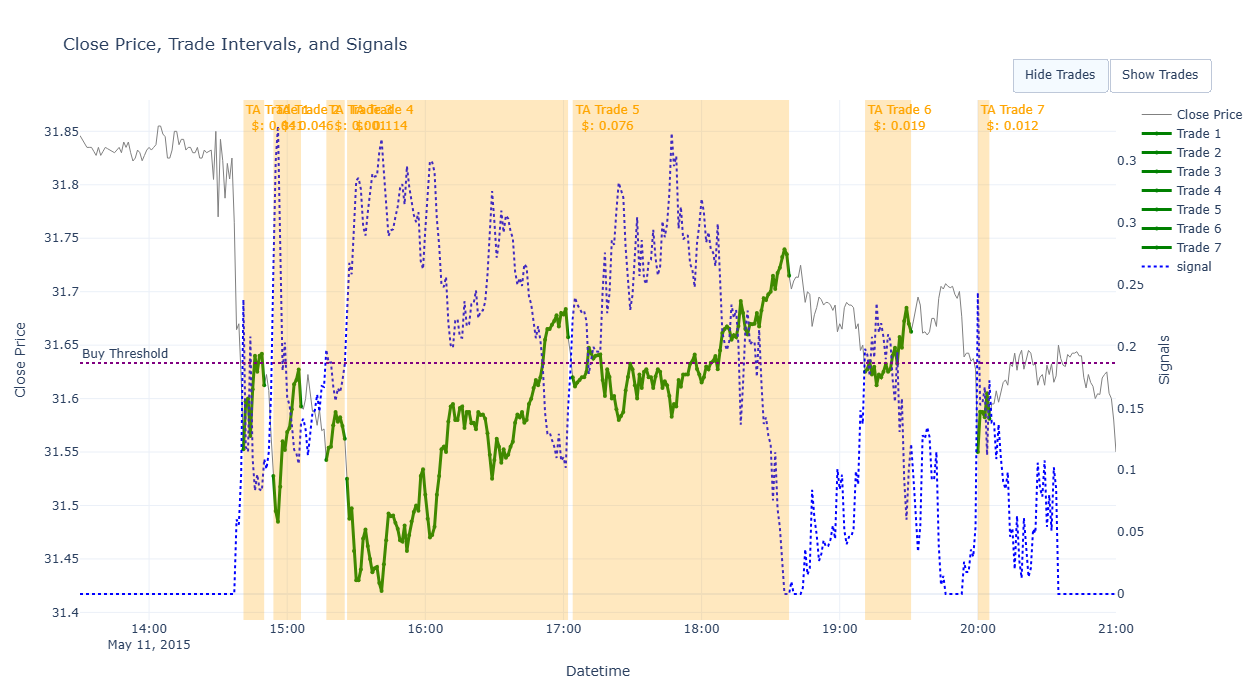


* Performance for 2015-05-11 *
  Buy & Hold Return ($): -0.239
  Strategy Return ($): 0.308
  Trades Returns ($): [0.041, 0.046, 0.001, 0.114, 0.076, 0.019, 0.012]

=== Processing trading day 2015-05-12 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


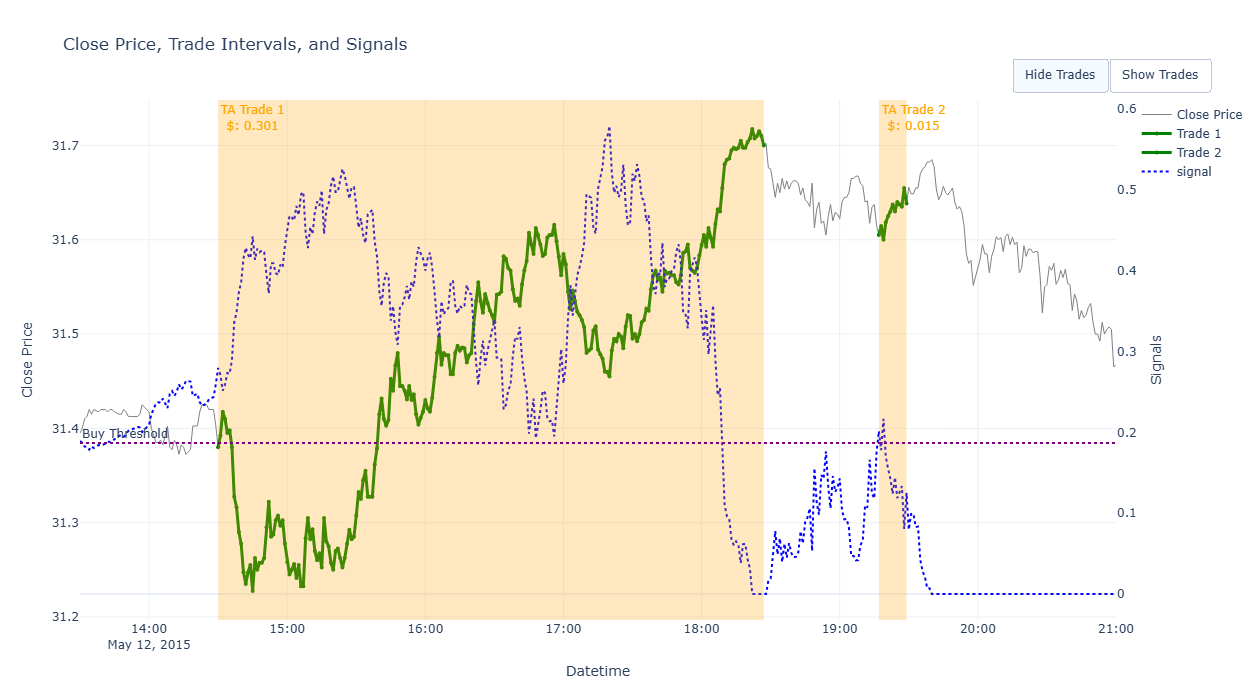


* Performance for 2015-05-12 *
  Buy & Hold Return ($): 0.069
  Strategy Return ($): 0.316
  Trades Returns ($): [0.301, 0.015]

=== Processing trading day 2015-05-13 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


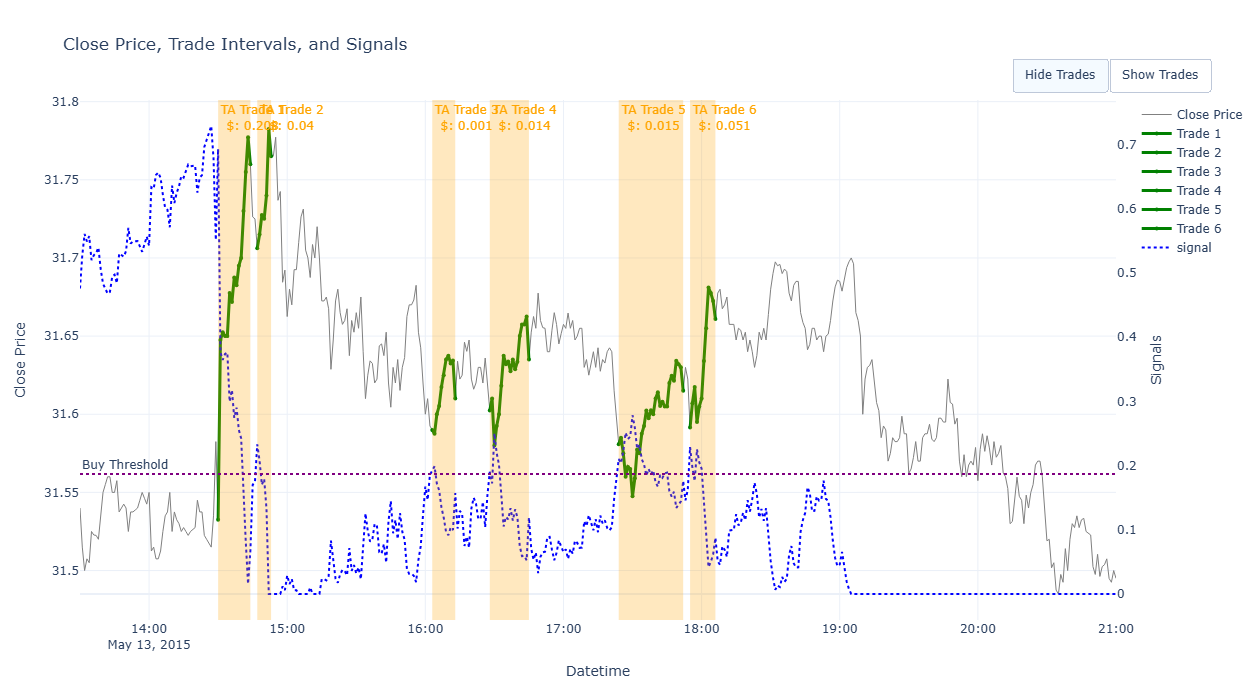


* Performance for 2015-05-13 *
  Buy & Hold Return ($): -0.056
  Strategy Return ($): 0.329
  Trades Returns ($): [0.208, 0.04, 0.001, 0.014, 0.015, 0.051]

=== Processing trading day 2015-05-14 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


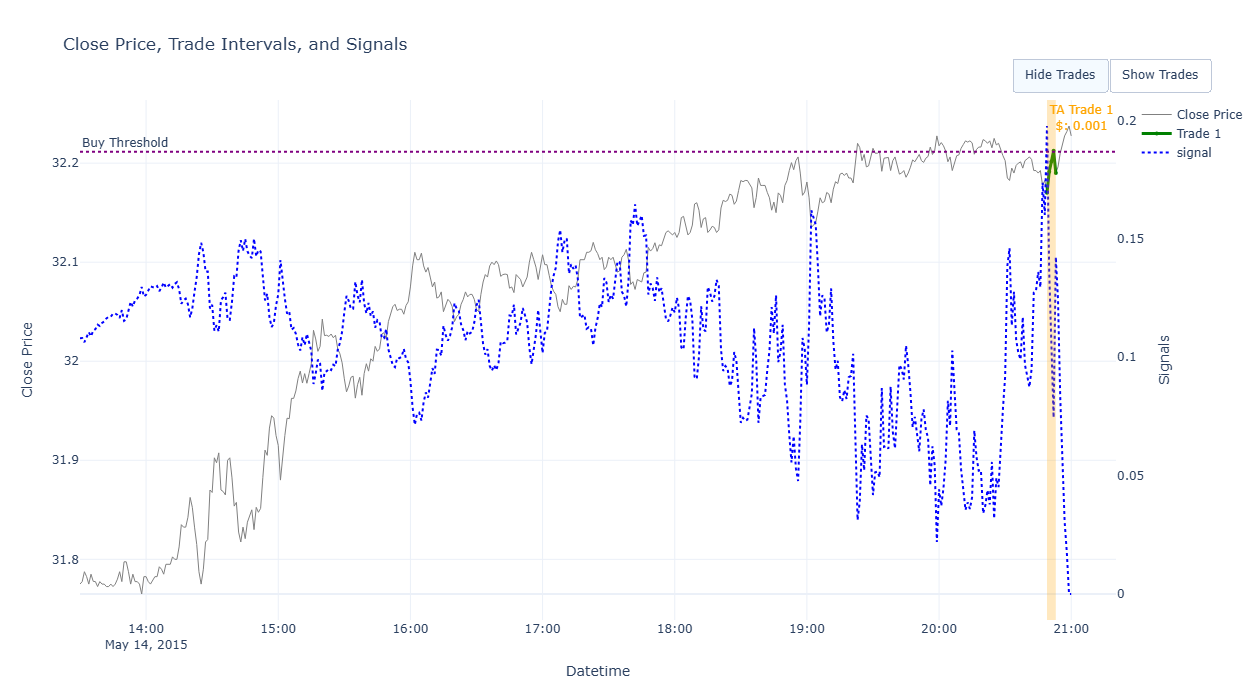


* Performance for 2015-05-14 *
  Buy & Hold Return ($): 0.341
  Strategy Return ($): 0.001
  Trades Returns ($): [0.001]

=== Processing trading day 2015-05-15 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


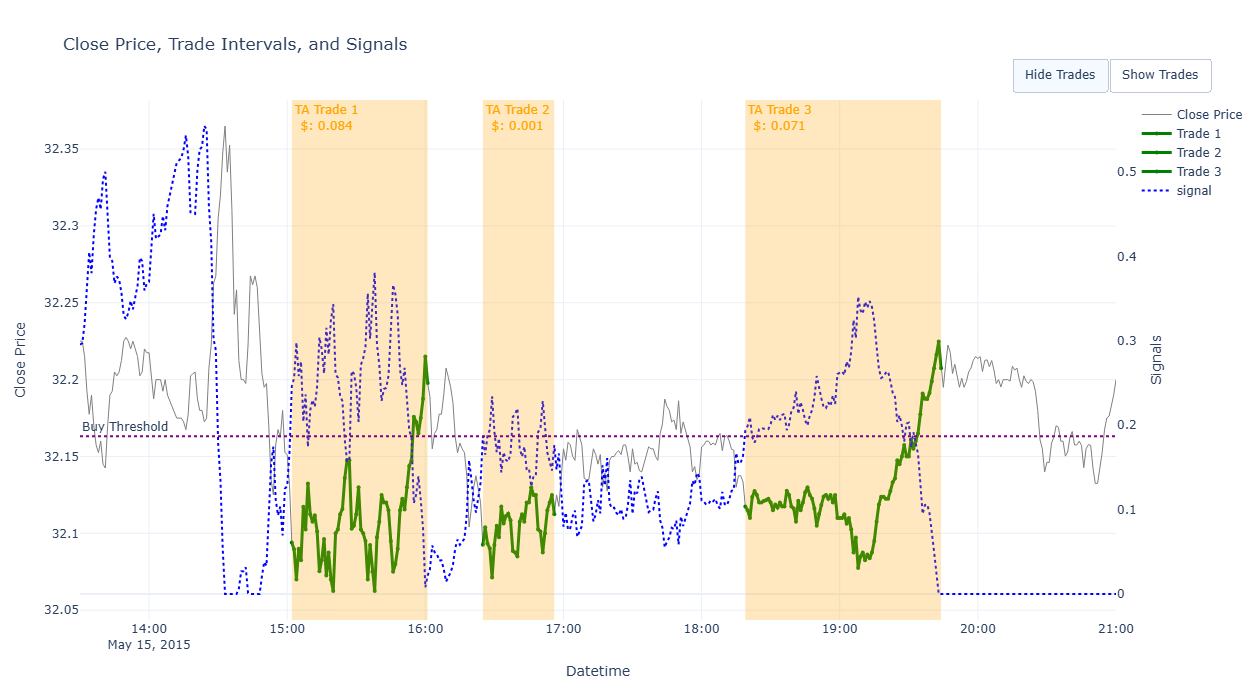


* Performance for 2015-05-15 *
  Buy & Hold Return ($): -0.124
  Strategy Return ($): 0.156
  Trades Returns ($): [0.084, 0.001, 0.071]

=== Processing trading day 2015-05-18 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


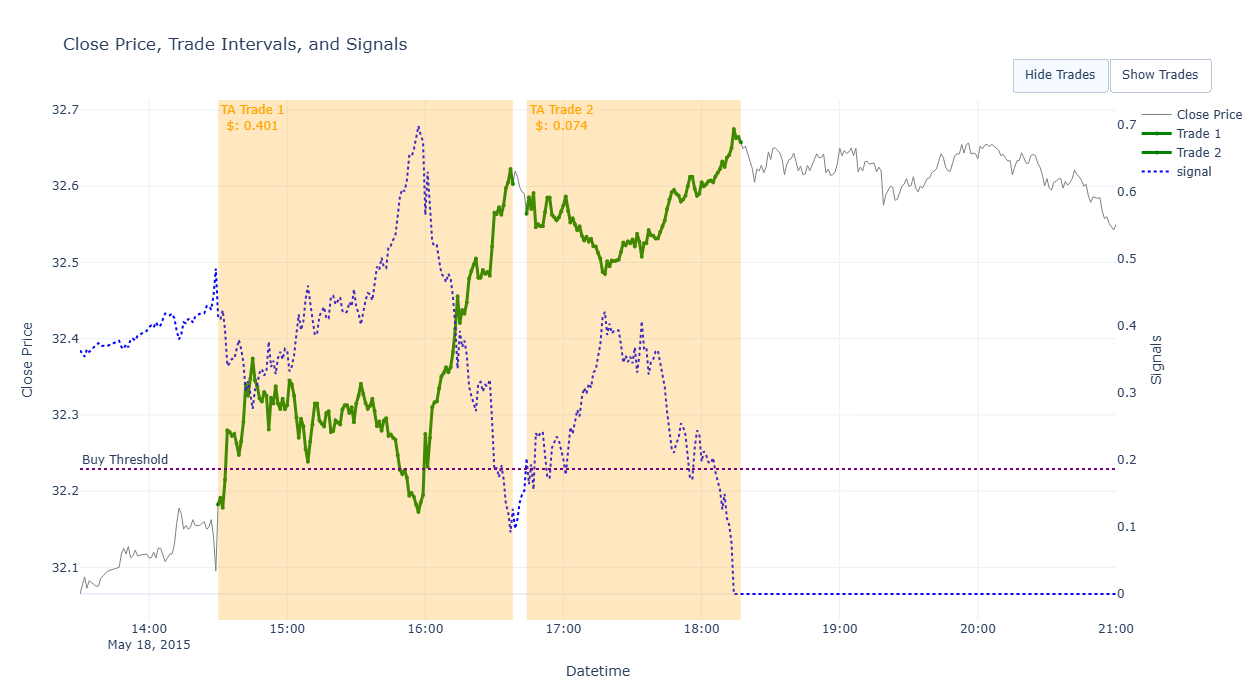


* Performance for 2015-05-18 *
  Buy & Hold Return ($): 0.348
  Strategy Return ($): 0.475
  Trades Returns ($): [0.401, 0.074]

=== Processing trading day 2015-05-19 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


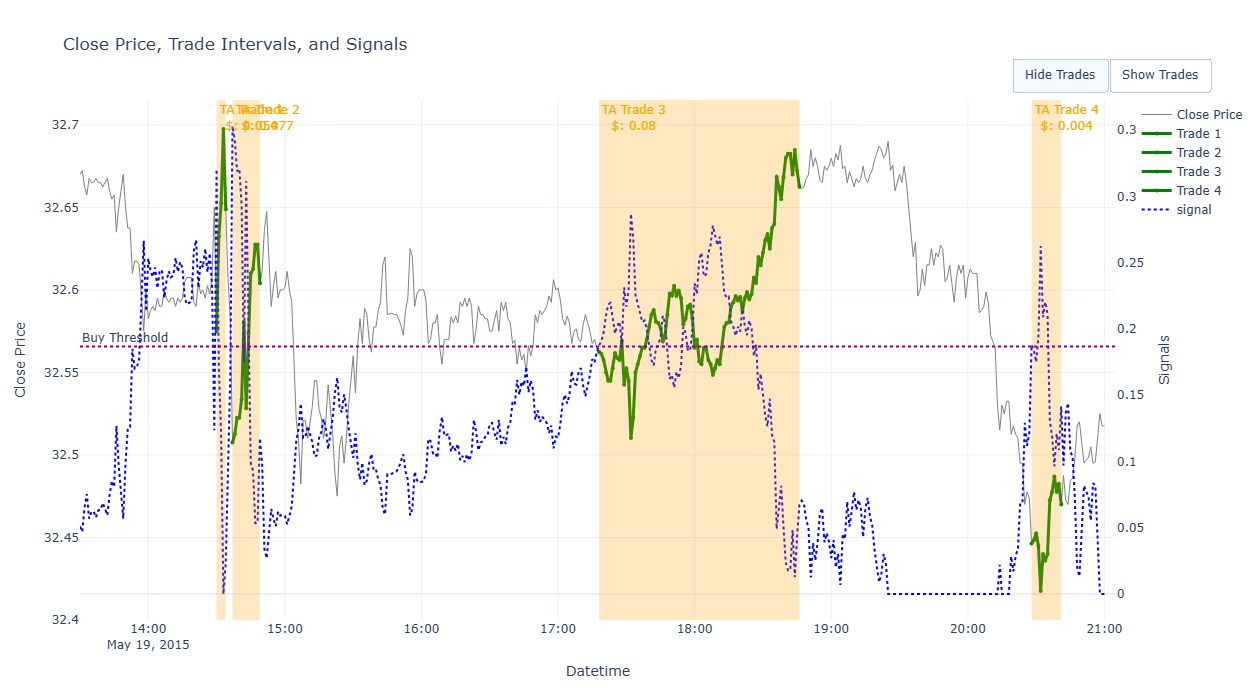


* Performance for 2015-05-19 *
  Buy & Hold Return ($): -0.077
  Strategy Return ($): 0.216
  Trades Returns ($): [0.054, 0.077, 0.08, 0.004]

=== Processing trading day 2015-05-20 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


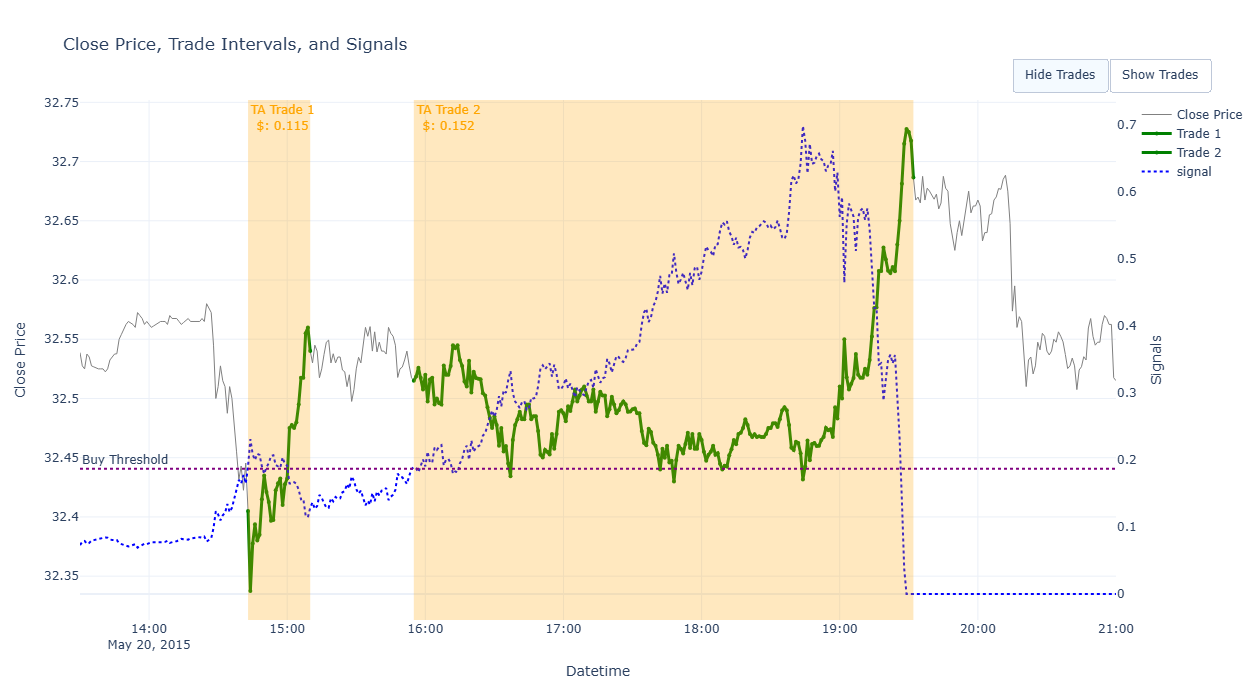


* Performance for 2015-05-20 *
  Buy & Hold Return ($): -0.015
  Strategy Return ($): 0.268
  Trades Returns ($): [0.115, 0.152]

=== Processing trading day 2015-05-21 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


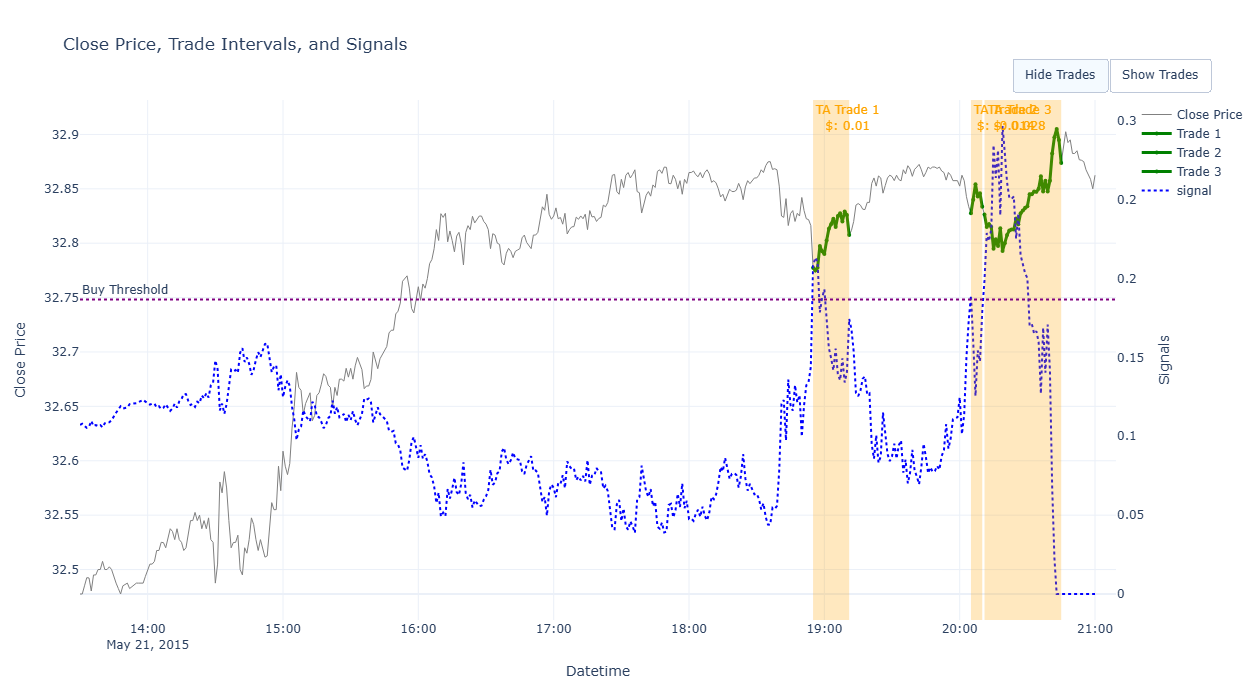


* Performance for 2015-05-21 *
  Buy & Hold Return ($): 0.355
  Strategy Return ($): 0.024
  Trades Returns ($): [0.01, -0.014, 0.028]

=== Processing trading day 2015-05-22 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


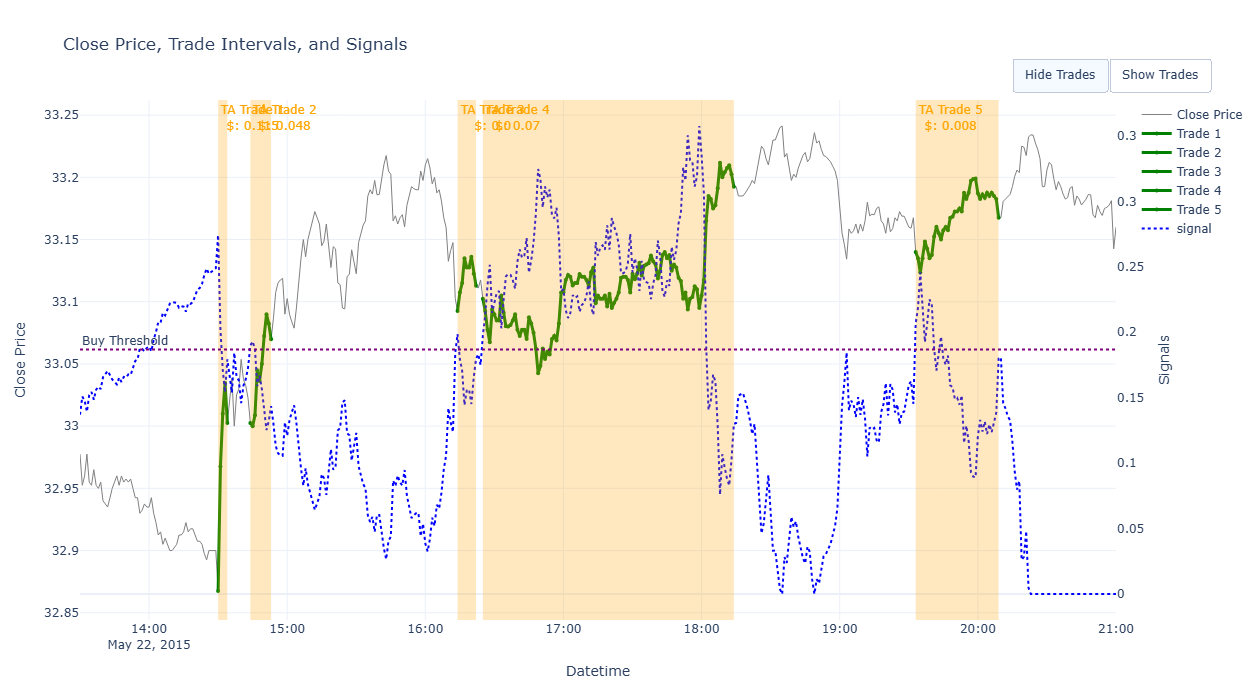


* Performance for 2015-05-22 *
  Buy & Hold Return ($): 0.273
  Strategy Return ($): 0.241
  Trades Returns ($): [0.115, 0.048, 0.0, 0.07, 0.008]

=== Processing trading day 2015-05-26 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


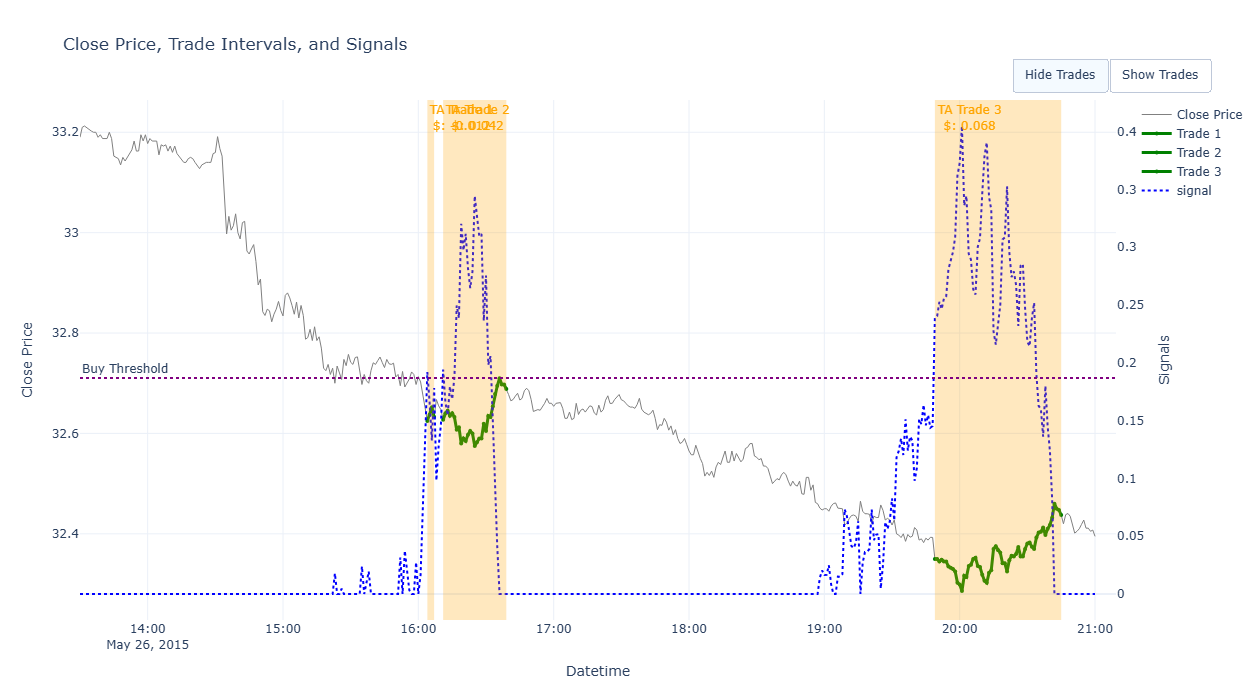


* Performance for 2015-05-26 *
  Buy & Hold Return ($): -0.784
  Strategy Return ($): 0.098
  Trades Returns ($): [-0.012, 0.042, 0.068]

=== Processing trading day 2015-05-27 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


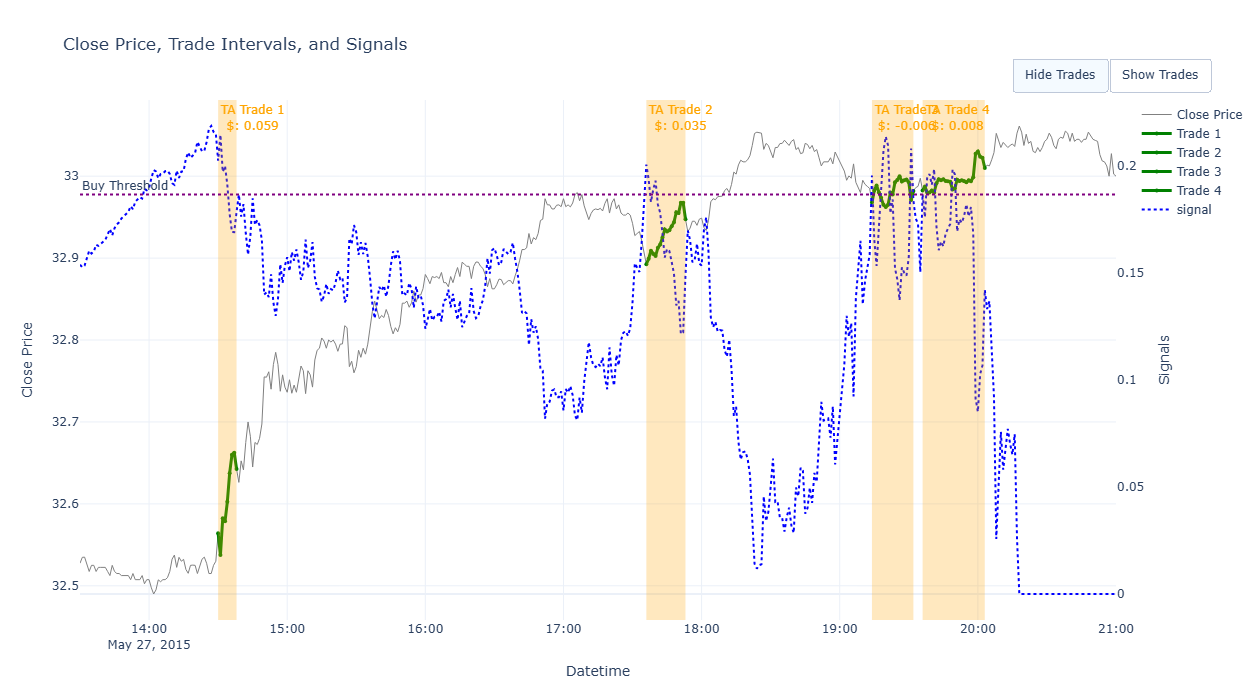


* Performance for 2015-05-27 *
  Buy & Hold Return ($): 0.416
  Strategy Return ($): 0.096
  Trades Returns ($): [0.059, 0.035, -0.006, 0.008]

=== Processing trading day 2015-05-28 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


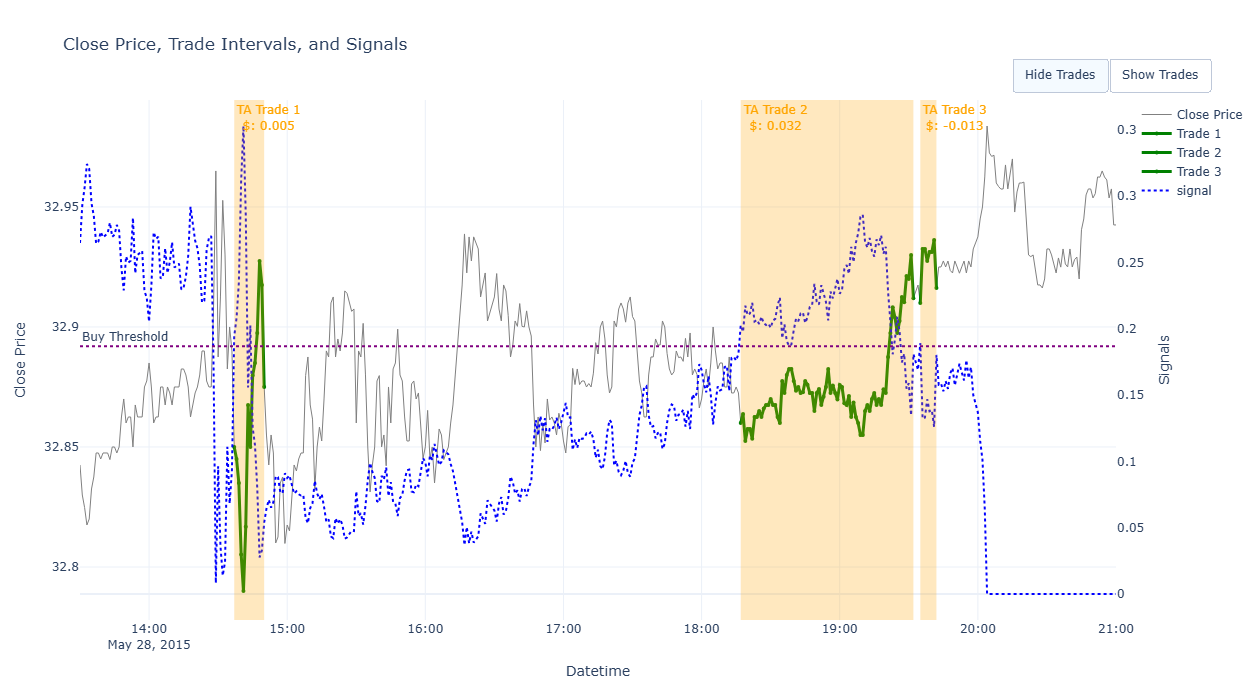


* Performance for 2015-05-28 *
  Buy & Hold Return ($): 0.035
  Strategy Return ($): 0.024
  Trades Returns ($): [0.005, 0.032, -0.013]

=== Processing trading day 2015-05-29 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


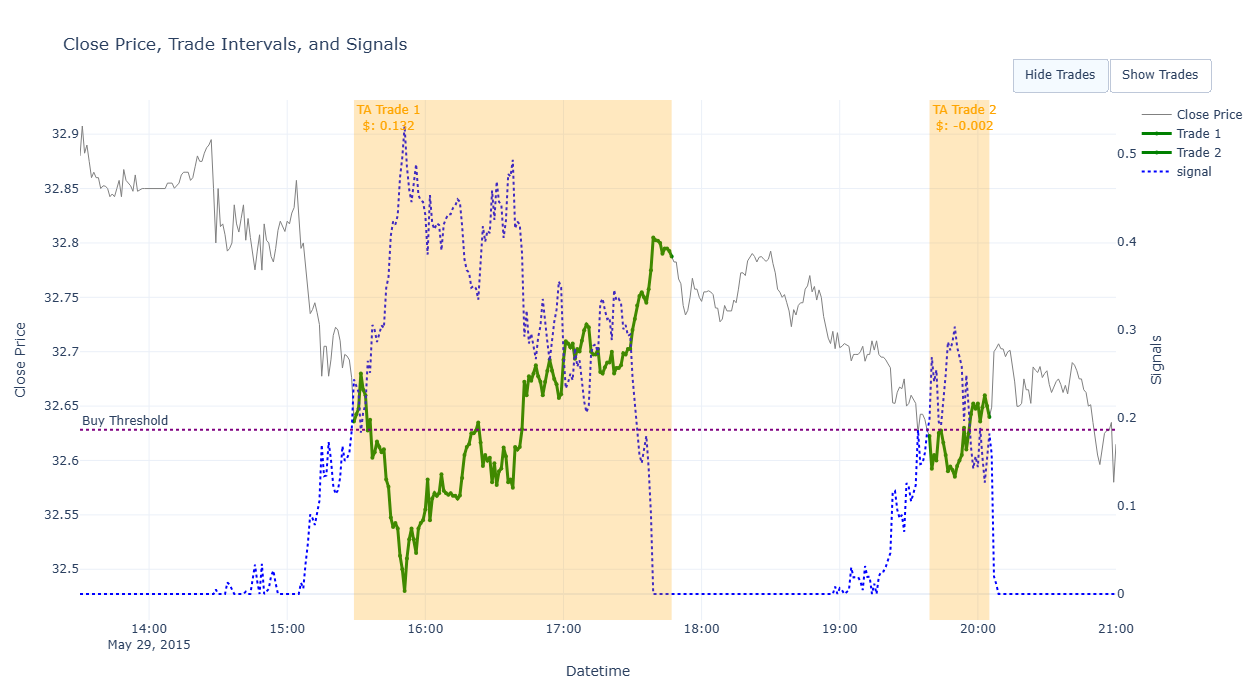


* Performance for 2015-05-29 *
  Buy & Hold Return ($): -0.255
  Strategy Return ($): 0.13
  Trades Returns ($): [0.132, -0.002]

Overall Summary (2015-05-01 = 31.5895 → 2015-05-29 = 32.6052)

One-time buy&hold gain: 1.016
Buy & Hold – each day ($): 0.113
Strategy Return ($): 4.664
Trades Count: 75
Strategy return per trade: 0.062
Num. trading days: 20
Strategy return per trading day: 0.233


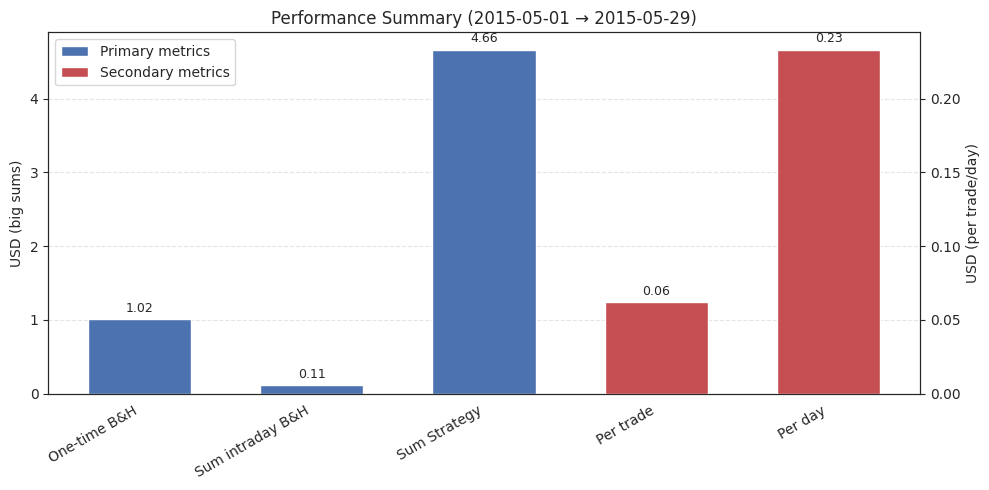


Full‐run mode
• Running trading pipeline on full dataset …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …

Full‐period performance:

Overall Summary (2004-01-02 = 0.7727 → 2025-06-18 = 196.4810)

One-time buy&hold gain: 195.708
Buy & Hold – each day ($): -121.224
Strategy Return ($): 3777.004
Trades Count: 31886
Strategy return per trade: 0.118
Num. trading days: 5400
Strategy return per trading day: 0.699


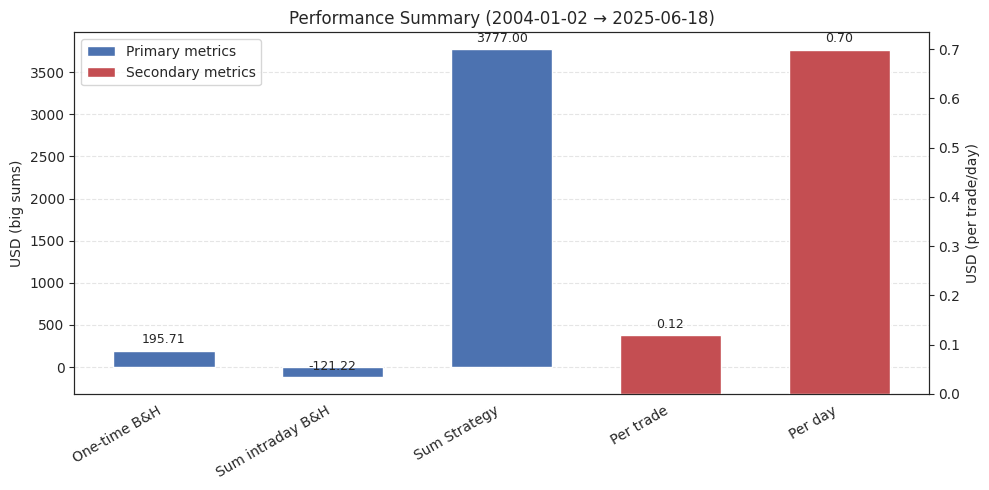


Test‐period performance:

Overall Summary (2022-03-28 = 172.7518 → 2025-06-18 = 196.4810)

One-time buy&hold gain: 23.729
Buy & Hold – each day ($): -54.954
Strategy Return ($): 1908.934
Trades Count: 4571
Strategy return per trade: 0.418
Num. trading days: 810
Strategy return per trading day: 2.357


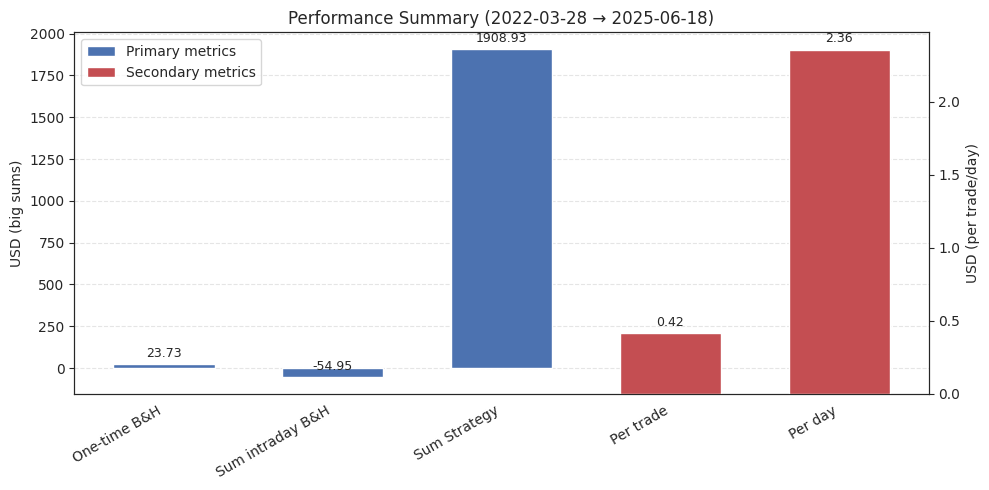


• Saving signals CSV …
Saved to dfs_training/AAPL_2_sign.csv


In [9]:
df_fin = saveDF_checkDAY(
                        df=df,
                        hyperparams=best_params
                        )

df_fin

In [ ]:
# Group by month
period = df_fin.index.to_period('M')

# Monthly stats for signal
signal_stats = df_fin.groupby(period)['signal'].agg(
    signal_min='min',
    signal_max='max',
    signal_mean='mean',
    signal_median='median'
)

# Monthly close return: (max - min) / min
close_return = df_fin.groupby(period)['close'].agg(
    close_return=lambda x: np.nan if x.min() == 0 else (x.max() - x.min()) / x.min()
)

# Combine into one DataFrame
monthly_stats = signal_stats.join(close_return)


# --------------------------------------------------
# Now plot histograms of signal for each year
# --------------------------------------------------

sns.set(style="whitegrid")
unique_years = sorted(df_fin.index.year.unique())

for y in unique_years:
    subset = df_fin[df_fin.index.year == y]['signal']
    
    plt.figure(figsize=(8, 4))
    sns.histplot(subset, bins=30, kde=False, color="skyblue")
    plt.title(f"Distribution of signal in {y}", fontsize=14)
    plt.xlabel("signal", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.tight_layout()
    plt.show()

monthly_stats
